In [1]:
import os

# Set the path to the directory containing the .so files, not the file itself
cuda_path = "/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib"

# Prepend it to the LD_LIBRARY_PATH
os.environ["LD_LIBRARY_PATH"] = cuda_path + ":" + os.environ.get("LD_LIBRARY_PATH", "")

# Verify it
print(os.environ["LD_LIBRARY_PATH"])

/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib:/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib/:


In [2]:
# !export LD_LIBRARY_PATH=/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib/libnvrtc.so.12:$LD_LIBRARY_PATH

In [3]:
!echo $LD_LIBRARY_PATH

/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib:/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib/:


In [4]:
from rich.jupyter import display
%load_ext cudf.pandas
import pandas as pd
import cv2 as cv
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from cuml.preprocessing import MinMaxScaler
from scipy.stats import mode
import optuna
from cuml.model_selection import train_test_split
import cupy as cp

import numpy as np
from scipy.stats import skew
import optuna.visualization as vis

In [5]:
train_df = pd.read_csv("./dataset/splits/train.csv", index_col='index')
train_df.head()
test_df = pd.read_csv("./dataset/splits/test.csv", index_col='index')
test_df.head()

,clip_name,clip_path,label,encoded_label
index,,,,
0,v_Diving_g25_c04.avi,./dataset/Diving/v_Diving_g25_c04.avi,Diving,0
1,v_Diving_g23_c01.avi,./dataset/Diving/v_Diving_g23_c01.avi,Diving,0
2,v_Diving_g16_c02.avi,./dataset/Diving/v_Diving_g16_c02.avi,Diving,0
3,v_Diving_g08_c06.avi,./dataset/Diving/v_Diving_g08_c06.avi,Diving,0
4,v_Diving_g13_c01.avi,./dataset/Diving/v_Diving_g13_c01.avi,Diving,0


In [6]:
def manual_normalize(frame):
    mean, std = cv.meanStdDev(frame)
    mean = mean.flatten()
    std = std.flatten()
    return (frame - mean) / std

def open_cv_normalize(frame):
    return cv.normalize(frame, None, alpha=0, beta=1.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

def open_cv_normalization_255(frame):
    return cv.normalize(frame, None, alpha=0, beta=255,
                               norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)


In [7]:
def color_segmentation(frame):
    rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    resized_rgb = cv.resize(rgb_frame, (224, 224), interpolation=cv.INTER_CUBIC)
    resized_hsv = cv.resize(hsv_frame, (224, 224), interpolation=cv.INTER_CUBIC)

    hist_features = {}
    for i, col in enumerate(['red', 'green', 'blue']):
        hist = cv.calcHist(resized_rgb, [i], None, [256], [0, 256])
        hist_features[col] = hist.flatten()

    moments = []
    for i in range(3):
        channel = resized_hsv[:, :, i]
        mean = cp.mean(channel)
        std = cp.std(channel)
        skewness = skew(channel.flatten())
        if np.isnan(skewness):
            skewness = 0
        moments.append([mean, std, skewness])

    avg_color = cp.mean(resized_rgb, axis=(0, 1))
    return hist_features, moments, avg_color


In [8]:
def add_color_feature_pipeline(index, file_path) -> list:
    file = cv.VideoCapture(file_path)
    results = []
    while file.isOpened():
        if not file:
            print("Error opening video stream or file")
        ret, frame = file.read()

        if ret:
            hist_features, moments, avg_color = color_segmentation(frame)

            results.append({'index': index,
                'moments_mean_h': moments[0][0], 'moments_std_h': moments[0][1], 'moments_skew_h': moments[0][2],
                'moments_mean_s': moments[1][0], 'moments_std_s': moments[1][1], 'moments_skew_s': moments[1][2],
                'moments_mean_v': moments[2][0], 'moments_std_v': moments[2][1], 'moments_skew_v': moments[2][2],
                'avg_color_r': avg_color[0], 'avg_color_g': avg_color[1], 'avg_color_b': avg_color[2]})
        else:
            break
    file.release()
    return results

In [9]:
COLOR_FEATURE_COLUMNS = [
    "moments_mean_h", "moments_std_h", "moments_skew_h",
    "moments_mean_s", "moments_std_s", "moments_skew_s",
    "moments_mean_v", "moments_std_v", "moments_skew_v",
    "avg_color_r", "avg_color_g", "avg_color_b",
]


In [10]:

scaler = MinMaxScaler()


def process_df(df, is_test=False):
    features = []
    for index, row in df.iterrows():
        features += add_color_feature_pipeline(index, row.clip_path)

    color_df = pd.DataFrame(
        columns=['index', 'moments_mean_h', 'moments_std_h', 'moments_skew_h', 'moments_mean_s', 'moments_std_s',
                 'moments_skew_s', 'moments_mean_v', 'moments_std_v', 'moments_skew_v', 'avg_color_r', 'avg_color_g',
                 'avg_color_b'],
        data=features)

    for f in COLOR_FEATURE_COLUMNS:
        color_df[f] = color_df[f].astype(float)
        if is_test:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.transform(color_df[COLOR_FEATURE_COLUMNS])
        else:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.fit_transform(color_df[COLOR_FEATURE_COLUMNS])
    return color_df


In [11]:
def train_pipeline():
    train_color_df = process_df(train_df)
    merged_df = pd.merge(train_df, train_color_df, on='index', how='inner')
    output = merged_df['encoded_label']
    merged_df = merged_df.drop(columns=['index', 'clip_path', 'clip_name', 'label', 'encoded_label'])
    return merged_df, output


In [12]:
def test_pipeline(model):
    test_color_df = process_df(test_df, is_test=True)
    merged_df = pd.merge(test_df, test_color_df, on='index', how='inner')
    merged_df = merged_df.drop(columns=['clip_path', 'clip_name', 'label'])

    result = []
    for video_id, group in merged_df.groupby('index'):
        print(video_id)
        df = group[COLOR_FEATURE_COLUMNS]
        output = model.predict(df)
        final_ans = mode(output).mode
        expected = group['encoded_label'].values[0]
        print(f'SVM: {final_ans}, Expected: {expected}')
        result.append({
            "video_id": video_id,
            "prediction": final_ans,
            "expected": expected,
            "correct": final_ans == expected,
        })

    ans_df = pd.DataFrame(result)
    print(f"ans - {ans_df.correct.sum()} total - {len(ans_df)}")
    print('classification report:')
    print(classification_report(ans_df['expected'], ans_df['prediction']))

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(ans_df['expected'], ans_df['prediction'], ax=ax, cmap='Blues')

    model_prob = model.predict_proba(merged_df[COLOR_FEATURE_COLUMNS])
    fig, ax = plt.subplots(figsize=(12, 5))
    for i, class_label in enumerate(model.classes_):
        PrecisionRecallDisplay.from_predictions(merged_df['encoded_label'] == class_label, model_prob[:, i], name=class_label, ax=ax)
    ax.set_title('Precision-Recall curve (One vs Rest)')
    plt.show()


In [13]:
X, Y = train_pipeline()

/tmp/ipykernel_606116/1789944484.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(channel.flatten())


In [14]:
def objective_function(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params)
    model.fit(X, Y)
    return model.score(X, Y)

study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=10, show_progress_bar=True, n_jobs=-1)

[I 2026-01-31 01:56:05,678] A new study created in memory with name: no-name-0185323f-8396-4484-8d94-1a7336462b80


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_606116/4116746377.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
/tmp/ipykernel_606116/4116746377.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),


[I 2026-01-31 01:56:29,614] Trial 6 finished with value: 0.6902169132522914 and parameters: {'C': 0.02424551650095884, 'gamma': 0.040888622936225645, 'kernel': 'linear'}. Best is trial 6 with value: 0.6902169132522914.
[I 2026-01-31 01:56:29,633] Trial 8 finished with value: 0.6297697165877945 and parameters: {'C': 0.941437092730688, 'gamma': 0.001476656116164482, 'kernel': 'rbf'}. Best is trial 6 with value: 0.6902169132522914.
[I 2026-01-31 01:56:31,382] Trial 1 finished with value: 0.8764491670038527 and parameters: {'C': 0.2648358467646169, 'gamma': 0.4352088821194799, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8764491670038527.
[I 2026-01-31 01:56:33,278] Trial 2 finished with value: 0.41016483999788894 and parameters: {'C': 0.019103943562411633, 'gamma': 0.0039348611051051524, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8764491670038527.
[I 2026-01-31 01:56:33,896] Trial 5 finished with value: 0.41016483999788894 and parameters: {'C': 0.4307740555691282, 'gamma': 0.00020

In [15]:
best_params = study.best_params
print(best_params)

{'C': 149.76595270806646, 'gamma': 7.798396946641588, 'kernel': 'poly'}


In [16]:

vis.plot_param_importances(study)

In [17]:
vis.plot_optimization_history(study)

In [18]:
# svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
#
# search_space = {
#     'C': (1e-3, 1e5, 'log-uniform'),
#     'gamma': (1e-3, 1e5, 'log-uniform'),
#     'kernel': ['linear', 'rbf', 'poly']
# }
#
# opt = BayesSearchCV(SVC(), search_space, n_iter=32, cv=5)
# opt.fit(X, Y)

In [19]:
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [20]:
# test_pipeline(rf_model)

In [23]:
model = SVC(**best_params, probability=True)
model.fit(X, Y)

SVC()

0
SVM: 2, Expected: 0
1
SVM: 0, Expected: 0
2
SVM: 2, Expected: 0
3
SVM: 2, Expected: 0
4
SVM: 1, Expected: 0
5
SVM: 0, Expected: 0
6
SVM: 2, Expected: 0
7
SVM: 2, Expected: 0
8
SVM: 2, Expected: 0
9
SVM: 0, Expected: 0
10
SVM: 2, Expected: 1
11
SVM: 2, Expected: 1
12
SVM: 1, Expected: 1
13
SVM: 2, Expected: 1
14
SVM: 2, Expected: 1
15
SVM: 2, Expected: 1
16
SVM: 2, Expected: 1
17
SVM: 2, Expected: 1
18
SVM: 2, Expected: 1
19
SVM: 2, Expected: 1
20
SVM: 2, Expected: 2
21
SVM: 2, Expected: 2
22
SVM: 2, Expected: 2
23
SVM: 2, Expected: 2
24
SVM: 2, Expected: 2
25
SVM: 2, Expected: 2
26
SVM: 2, Expected: 2
27
SVM: 2, Expected: 2
28
SVM: 2, Expected: 2
29
SVM: 1, Expected: 2
ans - 13 total - 30
classification report:
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.33      0.10      0.15        10
           2       0.38      0.90      0.53        10

    accuracy                           0.43        30
   ma

KeyError: (slice(None, None, None), 0)

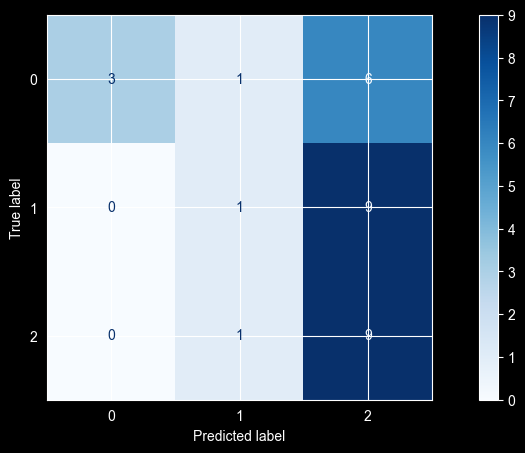

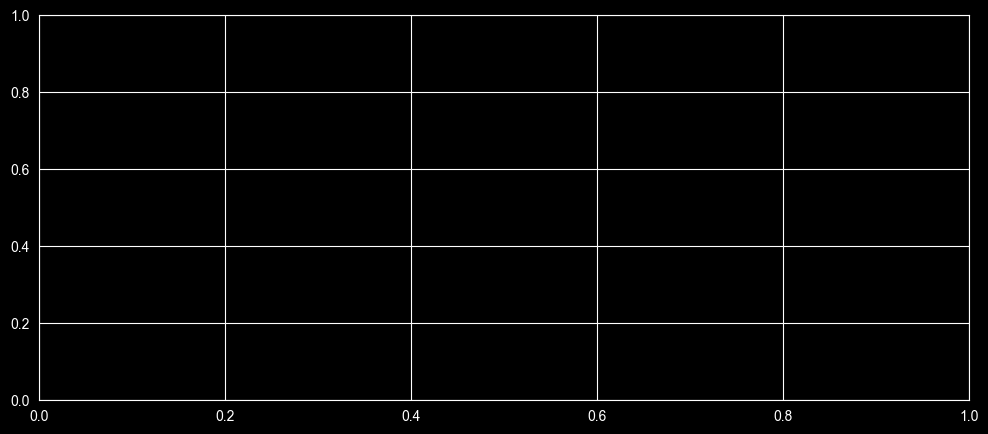

In [24]:
test_pipeline(model)
